### Timezone correction
- Assuming that all data is collected in one timezone(UTC)
- since countries are different so click payout data will get uniformly distributed across 24 hour time
- But if we convert all times (hour) to the respective time zones then we can see which times in that zone are higher payout generators

#### Method
- for countries with single timezone take the hour diff wrt UTC
- for countries with multi timezone take the average hour diff wrt UTC

### Browser and OS based inference
- Active learning features
- browser age
- os based device type, console/mobile/desktop/tablet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import math
import gc
import ipaddress
from urllib.parse import urlparse
from tldextract import extract

import sys
from pathlib import Path
d = Path().resolve().parent.parent
sys.path.insert(0, str(d))
import util.utils as utils
import util.plot_utils as plot_utils



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score


InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(precision=2)

In [3]:
project_name="click-prediction"
def get_file_location(filename):
    return "../data/%s/%s" % (project_name,filename)

In [4]:
df_conv_status = pd.read_csv("../data/%s/%s" % (project_name,"train-true_7.csv"))
df_fraud= pd.read_csv("../data/%s/%s" % (project_name,"train-fraud_7.csv"))
df = pd.read_csv("../data/%s/%s" % (project_name,"train_7.csv"))
df_test= pd.read_csv("../data/%s/%s" % (project_name,"test_7.csv"))

### Some util libs

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt

def get_all_column_names(df):
    return df.columns.values.tolist()


def count_distinct_values_column(df, colname):
    return pd.DataFrame(df[colname].value_counts(dropna=False)).rename(columns={0: "Count"})


def count_null_per_column(df):
    """Missing value count per column grouped by column name"""
    return pd.DataFrame(df.isnull().sum()).rename(columns={0:"# of Nulls"})

def unique_values_per_column(df):
    unique_counts = {}
    for idx in df.columns.values:
        #cnt=len(df[idx].unique())
        cnt = df[idx].nunique()
        unique_counts[idx]=cnt
    unique_ctr = pd.DataFrame([unique_counts]).T
    unique_ctr_2 = unique_ctr.rename(columns={0: '# Unique Values'})
    return unique_ctr_2


def particular_values_per_column(df,values):
    counts = {}
    for idx in df.columns.values:
        cnt=np.sum(df[idx].isin(values).values)
        counts[idx]=cnt
    ctr = pd.DataFrame([counts]).T
    ctr_2 = ctr.rename(columns={0: '# Values as %s'%values})
    return ctr_2

def get_column_datatypes(df):
    dtype = {}
    for idx in df.columns.values:
        dt = df[idx].dtype
        dtype[idx]=dt
    ctr = pd.DataFrame([dtype]).T
    ctr_2 = ctr.rename(columns={0: 'datatype'})
    return ctr_2

def column_summaries(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    particular_ctr = particular_values_per_column(df,[0])
    unique_ctr = unique_values_per_column(df)
    statistical_summary = df.describe().T
    datatypes = get_column_datatypes(df)
    skewed = pd.DataFrame(df.skew()).rename(columns={0: 'skew'})
    mis_val_table = pd.concat([mis_val, mis_val_percent, unique_ctr, particular_ctr,datatypes,skewed,statistical_summary], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% missing of Total Values'})
    return mis_val_table_ren_columns

def filter_dataframe(df,filter_columns):
    df_filtered = df
    for feature in filter_columns:
        values = filter_columns[feature]
        if(len(values)==1):
            df_filtered = df_filtered[df_filtered[feature]==values[0]]
        elif(len(values)==2):
            df_filtered = df_filtered[(df_filtered[feature]>=values[0]) & (df_filtered[feature]<=values[1])]
    return df_filtered

def filter_dataframe_percentile(df, filter_columns):
    df_filtered = df
    for feature in filter_columns:
        quantiles = filter_columns[feature]
        values = df[feature].quantile(quantiles).values
        if(len(values)==1):
            # if only one value present assume upper quantile
            df_filtered = df_filtered[df_filtered[feature]<=values[0]]
        elif(len(values)==2):
            df_filtered = df_filtered[(df_filtered[feature]>=values[0]) & (df_filtered[feature]<=values[1])]
    return df_filtered


def detect_nan_columns(df):
    columns = df.columns.values.tolist()
    for colname in columns:
        if(np.sum(np.isnan(df[colname]))>0):
            print(colname)
            
def plot_bar(df,columnx,columny,rounder):
    df[columnx+"_temp"] = df[columnx].round(rounder)
    dfr=df.groupby([columnx+"_temp"])[columny].sum()
    dfr=dfr.to_frame().reset_index()
    dfr.columns = [columnx,columny]
#     sns.barplot(x=columnx, y=columny, data=dfr,palette="Greens")
    dfr.plot.bar(columnx,columny)

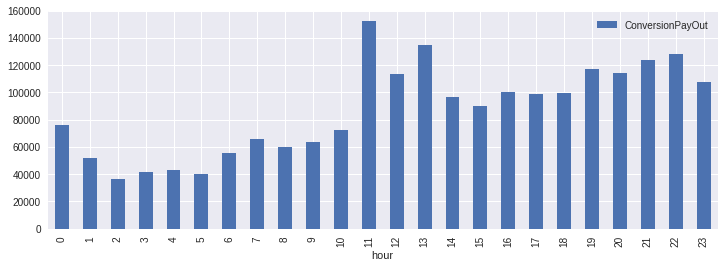

In [6]:
plot_bar(df_conv_status,"hour","ConversionPayOut",1)

In [7]:
from pytz import country_timezones
from pytz import timezone
from datetime import datetime, timedelta
timezone_country = {}
tzr = {}
tkr={}
offsets = {}
for countrycode in country_timezones:
    timezones = country_timezones[countrycode]
    tzr[countrycode] = timezones
    tkr[countrycode] ={}
    offsets[countrycode] ={}
    for tz in timezones:
        tkr[countrycode][tz] = timezone(tz)
        tnm=tkr[countrycode][tz].utcoffset(datetime(2009, 9, 1))
        offset = 0
        if tnm.days==-1:
            offset = tnm.days*(24*3600 - tnm.seconds)
        elif tnm.days==0:
            offset = tnm.seconds
        else:
            print(tnm)
        offsets[countrycode][tz] = offset/3600
        timezone_country[tz] = countrycode
        
country_avg_offset = {}
country_list = []
offset_list = []
for country in offsets:
    offset_sum=0
    count=0
    for region,offset in offsets[country].items():
        offset_sum+=offset
        count+=1
    
    offset_avg = offset_sum/count
    if offset_avg<-24:
        offset_avg = -24.0
    elif offset_avg>24:
        offset_avg=24.0
    country_avg_offset[country]=offset_sum/count
    country_list.append(country)
    offset_list.append(offset_sum/count)

country_avg_offset["IN"]
country_avg_offset["US"]

df_offsets=pd.DataFrame({"Country":country_list,"offset":offset_list})

5.5

-5.827586206896552

In [8]:
df_offsets[df_offsets["offset"]<0].head()

,Country,offset
3,AG,-4.000000
4,AI,-4.000000
9,AR,-3.083333
10,AS,-11.000000
13,AW,-4.000000


In [6]:
df_offsets[df_offsets["offset"]<0].head()

,Country,offset
3,AG,-4.000000
4,AI,-4.000000
9,AR,-3.083333
10,AS,-11.000000
13,AW,-4.000000


In [9]:
df_country = pd.read_csv("../data/%s/%s" % (project_name,"Country-encoding.csv"))

In [10]:
df_country = df_country.merge(df_offsets,on="Country",how="left")

In [11]:
df_country["Country"] = df_country["id"]

In [12]:
df_country.drop(['id'], axis = 1, inplace = True)



In [13]:
# -30 since any value within -12 to +12 is an offset
df_country["offset"].fillna(-30,inplace=True)
df_country.head()

,Country,offset
0,0,-30.0
1,1,-30.0
2,2,2.0
3,3,4.0
4,4,4.5


In [25]:
# df.drop(['offset'], axis = 1, inplace = True)
# df_test.drop(['offset'], axis = 1, inplace = True)
# df_fraud.drop(['offset'], axis = 1, inplace = True)
# df_conv_status.drop(['offset'], axis = 1, inplace = True)

In [26]:
df=df.merge(df_country,on="Country",how="left")
df_test=df_test.merge(df_country,on="Country",how="left")
df_fraud=df_fraud.merge(df_country,on="Country",how="left")
df_conv_status=df_conv_status.merge(df_country,on="Country",how="left")

In [27]:
df_conv_status.head()

,ID,Carrier,TrafficType,Device,Browser,OS,RefererUrl,ConversionPayOut,publisherId,subPublisherId,...,subnet,city,region_code,postal_code,Country,sub_domain,url,hour_temp,offset_hours,offset
0,1378,-1,1,388,1,1,2,4.55000,8620,0,...,222207,51056,807,54143,19,1,2,0,-7,7.000000
1,1720,44,1,964,4,1,2,2.65265,3050,0,...,193271,13013,260,2064,19,1,2,0,-7,7.000000
2,8623154,44,1,1054,4,1,2,9.77600,8642,0,...,193271,13013,260,2064,19,1,2,9,2,7.000000
3,42700934,44,1,388,2,1,2,1.32600,8531,0,...,193271,13013,260,2064,19,1,2,12,5,7.000000
4,3698,703,1,42,4,1,2,25.49300,3848,0,...,1469524,46440,727,14607,179,1,2,0,-8,7.740741


In [28]:
df_conv_status.dtypes

ID                        int64
Carrier                   int64
TrafficType               int64
Device                    int64
Browser                   int64
OS                        int64
RefererUrl                int64
ConversionPayOut        float64
publisherId               int64
subPublisherId            int64
advertiserCampaignId      int64
Fraud                     int64
conv_status               int64
dayofweek                 int64
hour                      int64
dayofyear                 int64
network                   int64
subnet                    int64
city                      int64
region_code               int64
postal_code               int64
Country                  object
sub_domain                int64
url                       int64
hour_temp                 int64
offset_hours              int64
offset                  float64
dtype: object

In [29]:
np.sum(df["offset"].isnull())

644

In [30]:
df_conv_status["offset"].fillna(-997,inplace=True)
df_fraud["offset"].fillna(-997,inplace=True)
df_test["offset"].fillna(-997,inplace=True)
df["offset"].fillna(-997,inplace=True)

In [31]:
df_conv_status["offset_hours"] = df_conv_status["hour"] - df_conv_status["offset"].round(0).astype(int)
df_fraud["offset_hours"] = df_fraud["hour"] - df_fraud["offset"].round(0).astype(int)
df_test["offset_hours"] = df_test["hour"] - df_test["offset"].round(0).astype(int)
df["offset_hours"] = df["hour"] - df["offset"].round(0).astype(int)

In [33]:
df_conv_status.loc[df_conv_status["offset_hours"]>=997,"offset_hours"] = -997
df_fraud.loc[df_fraud["offset_hours"]>=997,"offset_hours"] = -997
df_test.loc[df_test["offset_hours"]>=997,"offset_hours"] = -997
df.loc[df["offset_hours"]>=997,"offset_hours"] = -997

df_conv_status["offset_hours"].describe()


count    34524.000000
mean         7.358591
std         11.199824
min       -997.000000
25%          1.000000
50%          8.000000
75%         13.000000
max         53.000000
Name: offset_hours, dtype: float64

In [34]:
# Wrong this screws up rows
# df_conv_status[df_conv_status["offset_hours"]>24] = df_conv_status[df_conv_status["offset_hours"]>24] % 24 
# df_fraud[df_fraud["offset_hours"]>24] = df_fraud[df_fraud["offset_hours"]>24] %24
# df_test[df_test["offset_hours"]>24] = df_test[df_test["offset_hours"]>24]%24
# df[df["offset_hours"]>24] = df[df["offset_hours"]>24]%24

# df_conv_status[df_conv_status["offset_hours"]<-24] = df_conv_status[df_conv_status["offset_hours"]<-24] % 24 
# df_fraud[df_fraud["offset_hours"]<-24] = df_fraud[df_fraud["offset_hours"]<-24] %24
# df_test[df_test["offset_hours"]<-24] = df_test[df_test["offset_hours"]<-24]%24
# df[df["offset_hours"]<-24] = df[df["offset_hours"]<-24]%24

In [35]:
df_conv_status.loc[df_conv_status["offset_hours"]>24, 'offset_hours'] = df_conv_status.loc[df_conv_status["offset_hours"]>24, "offset_hours"] %24
df_fraud.loc[df_fraud["offset_hours"]>24, 'offset_hours'] = df_fraud.loc[df_fraud["offset_hours"]>24, "offset_hours"] %24
df_test.loc[df_test["offset_hours"]>24, 'offset_hours'] = df_test.loc[df_test["offset_hours"]>24, "offset_hours"] %24
df.loc[df["offset_hours"]>24, 'offset_hours'] = df.loc[df["offset_hours"]>24, "offset_hours"] %24

df_conv_status.loc[df_conv_status["offset_hours"]<-24, 'offset_hours'] = df_conv_status.loc[df_conv_status["offset_hours"]<-24, "offset_hours"] %24
df_fraud.loc[df_fraud["offset_hours"]<-24, 'offset_hours'] = df_fraud.loc[df_fraud["offset_hours"]<-24, "offset_hours"] %24
df_test.loc[df_test["offset_hours"]<-24, 'offset_hours'] = df_test.loc[df_test["offset_hours"]<-24, "offset_hours"] %24
df.loc[df["offset_hours"]<-24, 'offset_hours'] = df.loc[df["offset_hours"]<-24, "offset_hours"] %24



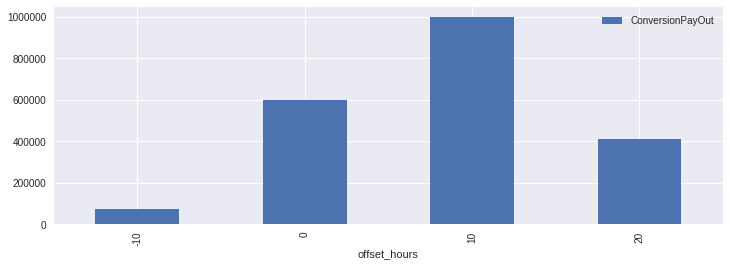

In [39]:
plot_bar(df_conv_status,"offset_hours","ConversionPayOut",-1)

In [41]:

# df_conv_status.drop(['offset_hours_temp'], axis = 1, inplace = True)
df_conv_status.drop(['hour_temp'], axis = 1, inplace = True)
df_conv_status.dtypes

ID                        int64
Carrier                   int64
TrafficType               int64
Device                    int64
Browser                   int64
OS                        int64
RefererUrl                int64
ConversionPayOut        float64
publisherId               int64
subPublisherId            int64
advertiserCampaignId      int64
Fraud                     int64
conv_status               int64
dayofweek                 int64
hour                      int64
dayofyear                 int64
network                   int64
subnet                    int64
city                      int64
region_code               int64
postal_code               int64
Country                  object
sub_domain                int64
url                       int64
offset_hours              int64
offset                  float64
dtype: object

### Additional Os Browser Details

In [42]:
df_os_encoding = pd.read_csv("../data/%s/%s" % (project_name,"os-encoding-extra.csv"))
df_browser_encoding = pd.read_csv("../data/%s/%s" % (project_name,"browser-encoding-extra.csv"))

In [43]:
df_os_encoding.dtypes
df_browser_encoding.dtypes

id                    int64
os                   object
device_type_word     object
old_or_new          float64
device_type         float64
dtype: object

id                   int64
browser             object
browser_age        float64
desktop_browser    float64
dtype: object

In [44]:
df_os_encoding.drop(['device_type_word'], axis = 1, inplace = True)
df_os_encoding["OS"] = df_os_encoding["id"]
df_os_encoding.drop(['id'], axis = 1, inplace = True)

In [45]:
df_browser_encoding["Browser"] = df_browser_encoding["id"]
df_browser_encoding.drop(['id'], axis = 1, inplace = True)

In [46]:
df_os_encoding.drop(['os'], axis = 1, inplace = True)

In [47]:
df_browser_encoding.drop(['browser'], axis = 1, inplace = True)

In [48]:
df_os_encoding.dtypes
df_browser_encoding.dtypes

old_or_new     float64
device_type    float64
OS               int64
dtype: object

browser_age        float64
desktop_browser    float64
Browser              int64
dtype: object

In [49]:
def add_os_data(df,df_os_encoding):
    df=df.merge(df_os_encoding,on="OS",how="left")
    return df

def add_browser_data(df,df_browser_encoding):
    df=df.merge(df_browser_encoding,on="Browser",how="left")
    return df

In [50]:
df=add_os_data(df,df_os_encoding)
df_conv_status=add_os_data(df_conv_status,df_os_encoding)
gc.collect()
df_fraud=add_os_data(df_fraud,df_os_encoding)
df_test=add_os_data(df_test,df_os_encoding)

gc.collect()


18981

94

In [51]:
df_conv_status.head()

,ID,Carrier,TrafficType,Device,Browser,OS,RefererUrl,ConversionPayOut,publisherId,subPublisherId,...,city,region_code,postal_code,Country,sub_domain,url,offset_hours,offset,old_or_new,device_type
0,1378,-1,1,388,1,1,2,4.55000,8620,0,...,51056,807,54143,19,1,2,-7,7.000000,1.0,1.0
1,1720,44,1,964,4,1,2,2.65265,3050,0,...,13013,260,2064,19,1,2,-7,7.000000,1.0,1.0
2,8623154,44,1,1054,4,1,2,9.77600,8642,0,...,13013,260,2064,19,1,2,2,7.000000,1.0,1.0
3,42700934,44,1,388,2,1,2,1.32600,8531,0,...,13013,260,2064,19,1,2,5,7.000000,1.0,1.0
4,3698,703,1,42,4,1,2,25.49300,3848,0,...,46440,727,14607,179,1,2,-8,7.740741,1.0,1.0


In [52]:
df=add_browser_data(df,df_browser_encoding)
df_conv_status=add_browser_data(df_conv_status,df_browser_encoding)
gc.collect()
df_fraud=add_browser_data(df_fraud,df_browser_encoding)
df_test=add_browser_data(df_test,df_browser_encoding)
gc.collect()

189

28

In [53]:
df_conv_status.head()
df_conv_status.dtypes

,ID,Carrier,TrafficType,Device,Browser,OS,RefererUrl,ConversionPayOut,publisherId,subPublisherId,...,postal_code,Country,sub_domain,url,offset_hours,offset,old_or_new,device_type,browser_age,desktop_browser
0,1378,-1,1,388,1,1,2,4.55000,8620,0,...,54143,19,1,2,-7,7.000000,1.0,1.0,2.0,0.0
1,1720,44,1,964,4,1,2,2.65265,3050,0,...,2064,19,1,2,-7,7.000000,1.0,1.0,3.0,2.0
2,8623154,44,1,1054,4,1,2,9.77600,8642,0,...,2064,19,1,2,2,7.000000,1.0,1.0,3.0,2.0
3,42700934,44,1,388,2,1,2,1.32600,8531,0,...,2064,19,1,2,5,7.000000,1.0,1.0,2.0,0.0
4,3698,703,1,42,4,1,2,25.49300,3848,0,...,14607,179,1,2,-8,7.740741,1.0,1.0,3.0,2.0


ID                        int64
Carrier                   int64
TrafficType               int64
Device                    int64
Browser                   int64
OS                        int64
RefererUrl                int64
ConversionPayOut        float64
publisherId               int64
subPublisherId            int64
advertiserCampaignId      int64
Fraud                     int64
conv_status               int64
dayofweek                 int64
hour                      int64
dayofyear                 int64
network                   int64
subnet                    int64
city                      int64
region_code               int64
postal_code               int64
Country                  object
sub_domain                int64
url                       int64
offset_hours              int64
offset                  float64
old_or_new              float64
device_type             float64
browser_age             float64
desktop_browser         float64
dtype: object

In [54]:
df_conv_status["old_or_new"].fillna(-997,inplace=True)
df_conv_status["old_or_new"] = df_conv_status["old_or_new"].astype(int)

df["old_or_new"].fillna(-997,inplace=True)
df["old_or_new"] = df["old_or_new"].astype(int)

df_fraud["old_or_new"].fillna(-997,inplace=True)
df_fraud["old_or_new"] = df_fraud["old_or_new"].astype(int)

df_test["old_or_new"].fillna(-997,inplace=True)
df_test["old_or_new"] = df_test["old_or_new"].astype(int)


df_conv_status["device_type"].fillna(-997,inplace=True)
df_conv_status["device_type"] = df_conv_status["device_type"].astype(int)

df["device_type"].fillna(-997,inplace=True)
df["device_type"] = df["device_type"].astype(int)

df_fraud["device_type"].fillna(-997,inplace=True)
df_fraud["device_type"] = df_fraud["device_type"].astype(int)

df_test["device_type"].fillna(-997,inplace=True)
df_test["device_type"] = df_test["device_type"].astype(int)


# 
df_conv_status["browser_age"].fillna(-997,inplace=True)
df_conv_status["browser_age"] = df_conv_status["browser_age"].astype(int)

df["browser_age"].fillna(-997,inplace=True)
df["browser_age"] = df["browser_age"].astype(int)

df_fraud["browser_age"].fillna(-997,inplace=True)
df_fraud["browser_age"] = df_fraud["browser_age"].astype(int)

df_test["browser_age"].fillna(-997,inplace=True)
df_test["browser_age"] = df_test["browser_age"].astype(int)

df_conv_status["desktop_browser"].fillna(-997,inplace=True)
df_conv_status["desktop_browser"] = df_conv_status["desktop_browser"].astype(int)

df["desktop_browser"].fillna(-997,inplace=True)
df["desktop_browser"] = df["desktop_browser"].astype(int)

df_fraud["desktop_browser"].fillna(-997,inplace=True)
df_fraud["desktop_browser"] = df_fraud["desktop_browser"].astype(int)

df_test["desktop_browser"].fillna(-997,inplace=True)
df_test["desktop_browser"] = df_test["desktop_browser"].astype(int)


In [56]:
df_test["Country"] = df_test["Country"].astype(int)
df_fraud["Country"] = df_fraud["Country"].astype(int)
df["Country"] = df["Country"].astype(int)
df_conv_status["Country"] = df_conv_status["Country"].astype(int)

In [57]:
df.dtypes
df_conv_status.dtypes

ID                        int64
Carrier                   int64
TrafficType               int64
Device                    int64
Browser                   int64
OS                        int64
RefererUrl                int64
ConversionPayOut        float64
publisherId               int64
subPublisherId            int64
advertiserCampaignId      int64
Fraud                     int64
conv_status               int64
dayofweek                 int64
hour                      int64
dayofyear                 int64
network                   int64
subnet                    int64
city                      int64
region_code               int64
postal_code               int64
Country                   int64
sub_domain                int64
url                       int64
offset_hours              int64
offset                  float64
old_or_new                int64
device_type               int64
browser_age               int64
desktop_browser           int64
dtype: object

ID                        int64
Carrier                   int64
TrafficType               int64
Device                    int64
Browser                   int64
OS                        int64
RefererUrl                int64
ConversionPayOut        float64
publisherId               int64
subPublisherId            int64
advertiserCampaignId      int64
Fraud                     int64
conv_status               int64
dayofweek                 int64
hour                      int64
dayofyear                 int64
network                   int64
subnet                    int64
city                      int64
region_code               int64
postal_code               int64
Country                   int64
sub_domain                int64
url                       int64
offset_hours              int64
offset                  float64
old_or_new                int64
device_type               int64
browser_age               int64
desktop_browser           int64
dtype: object

In [58]:
df.to_csv("train_8.csv",index=False)
df_conv_status.to_csv("train-true_8.csv",index=False)
df_fraud.to_csv("train-fraud_8.csv",index=False)
df_test.to_csv("test_8.csv",index=False)